In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import sys
from imp import reload
sys.path.append('..')
import support.data_functions as dfunc
import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
reload(dfunc)
testdf = dfunc.infer_all_census()
len(testdf.City.unique())

50

In [6]:
with open('/Users/adampah/Desktop/cities.txt', 'w') as wfile:
    for c,s in [','.join(l) for l in testdf.loc[:, ['City', 'State']].values.tolist():
        print('{0},{1}'.format(c,s), file=wfile)
        

In [31]:
tmergedf = dfunc.produce_merged_dataframe(census_inference = True)
len(tmergedf.City.unique())

50

In [32]:
census_set = set(testdf.City.unique())
merge_set = set(tmergedf.City.unique())

In [33]:
census_set.difference(merge_set)

set()

In [3]:
censusdf = dfunc.load_all_census()

In [4]:
cities = [x.split(' ') for x in list(set([' '.join(x) for x in censusdf.loc[:, ['City', 'State']].values]))]

In [5]:
racepops = [x for x in censusdf.columns.values if 'Pop' in x and ('Total' not in x and 'YoY' not in x \
                                                                  and 'Slope' not in x and'Frac' not in x)]


In [6]:
lin_form = '%s ~ Year'
quad_form = '%s ~ Year + np.power(Year, 2)'
ter_form = '%s ~ Year + np.power(Year, 2) + np.power(Year, 3)'
quart_form = '%s ~ Year + np.power(Year, 2) + np.power(Year, 3) + np.power(Year, 4)'
quint_form = '%s ~ Year + np.power(Year, 2) + np.power(Year, 3) + np.power(Year, 4), + np.power(Year, 5)'

In [150]:
calcs = []
for city, state in cities:
    for racepop in racepops:
        for i, form in enumerate([lin_form, quad_form, ter_form, quart_form]):
            subdf = censusdf[(censusdf.City == city) & (censusdf.State == state) & \
                             (censusdf[racepop]!=0)].loc[:, ['Year', racepop]].dropna()
            try:
                fitted = smf.ols(formula = form % racepop, data = subdf).fit()
                yeardf = pd.DataFrame(list(range(1960, 2011)), columns = ['Year'])
                calcs.append([city, state, racepop, i + 1, fitted.rsquared_adj])
            except:
                pass

In [141]:
rsquared_df = df[:]

In [151]:
adjdf = pd.DataFrame(calcs, columns = ['City', 'State', 'RacePop' ,'Form', 'RSquared'])

In [182]:
aggdf = censusdf[censusdf.TotalPop > 50000].groupby(['City', 'State']).agg(len)
large_city_df = pd.DataFrame(list(zip(aggdf[aggdf['BlackPop'] == 6].index.get_level_values('City'), \
                             aggdf[aggdf['BlackPop'] == 6].index.get_level_values('State')) ), 
                             columns = ['City', 'State'])

In [185]:
merge_adjdf = pd.merge(large_city_df, adjdf, on=['City', 'State'])

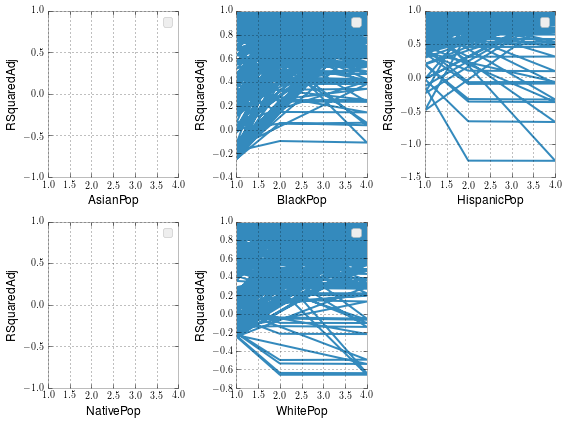

In [90]:
fig = plt.figure(figsize = (8, 6))

for i, race in enumerate(df.RacePop.unique()):
    ax = fig.add_subplot(2, 3, i+1)
    ax = df[df.RacePop == race].plot(ax = ax, y = 'RSquared', x='Form', by='City')
    ax.set_title('')
    ax.set_ylabel('RSquaredAdj')
    ax.set_xlabel(race)
    ax.set_axis_bgcolor('white')
    ax.legend('')

fig.suptitle('')
plt.tight_layout()

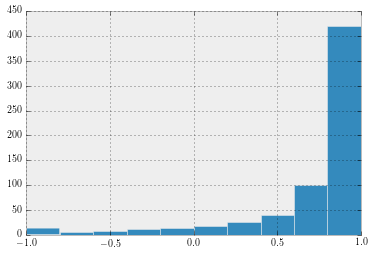

In [91]:
df.groupby(['City', 'RacePop']).RSquared.agg(max).hist()

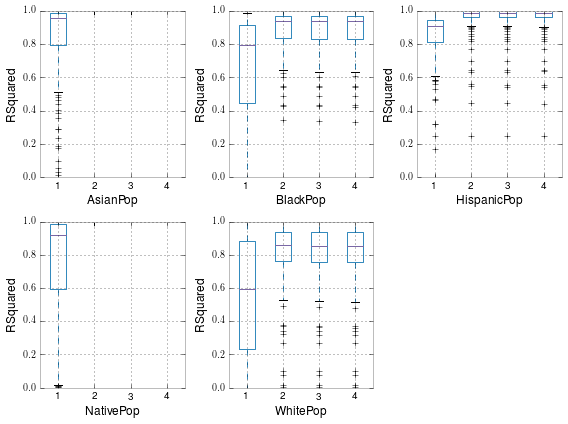

In [133]:
fig = plt.figure(figsize = (8, 6))

for i, race in enumerate(df.RacePop.unique()):
    ax = fig.add_subplot(2, 3, i+1)
    ax = df[df.RacePop == race].boxplot(ax = ax, column = 'RSquared', by='Form')
    ax.set_title('')
    ax.set_ylabel('RSquared')
    ax.set_xlabel(race)
    ax.set_axis_bgcolor('white')

fig.suptitle('')
plt.tight_layout()

Key is linear fit for asian and native, quad for black, hispanic, and white

In [45]:
delinqs = df[(df.RacePop == 'NativePop') & (df.Form == 1) & (df.RSquared < 0)]

In [27]:
smf.ols(formula = 'NativePop ~ Year', data = censusdf[censusdf.City == 'Norfolk']).fit().summary()

/Users/adampah/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NativePop   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                 -0.394
Method:                 Least Squares   F-statistic:                    0.4348
Date:                Mon, 09 Jan 2017   Prob (F-statistic):              0.629
Time:                        09:53:19   Log-Likelihood:                -15.771
No. Observations:                   3   AIC:                             35.54
Df Residuals:                       1   BIC:                             33.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   8079.6667   1.14e+04      0.710      0.607     -1.36e+05  1.53e+05
Year          -3.7500      5.687     -0.659      0.629       -76.009    68.509
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.531
Skew:                          -0.707   Prob(JB):                        0.767
Kurtosis:                       1.500   Cond. No.                     4.90e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

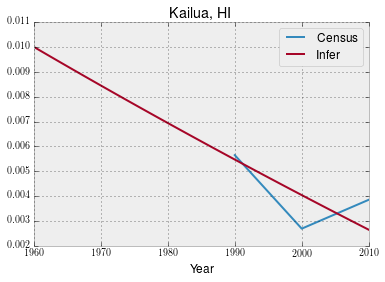

In [72]:
def plot_city(city, state, race):
    reload(dfunc)
    race_frac = race + 'PopFrac'
    try:
        pred_df = dfunc.infer_single_census('../../Data/census/{0}_{1}.csv'.format(state, city))
        #Hawaii example , -0.086466
        fig = plt.figure()
        ax = fig.add_subplot(111)
        subdf = censusdf[(censusdf.City == city) & (censusdf.State == state)][:]
        #Plot the real
        subdf.plot(x='Year', y= race_frac, label = 'Census', ax = ax)
        #Plot the fitted
        pred_df.plot(x='Year', y=race_frac, label = 'Infer', ax=ax)
        ax.set_title('{0}, {1}'.format(city, state))
    except TypeError:
        print('No {2} data for {0}, {1}'.format(city, state, race))
    
plot_city('Kailua', 'HI', 'Native')

No Native data for Kansas_City, MO


/Users/adampah/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


No Native data for Oklahoma_City, OK
No Native data for Kansas_City, KS


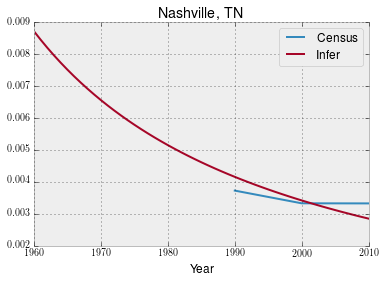

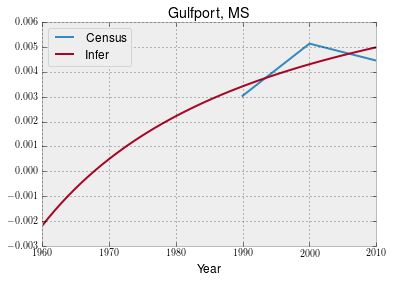

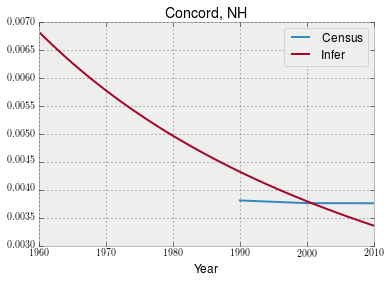

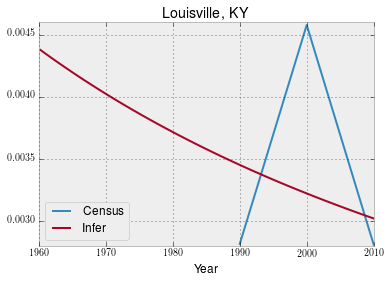

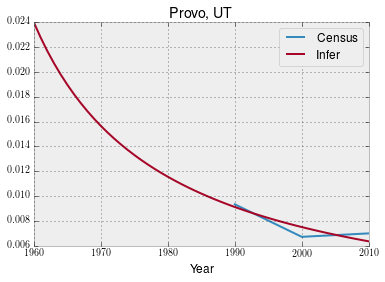

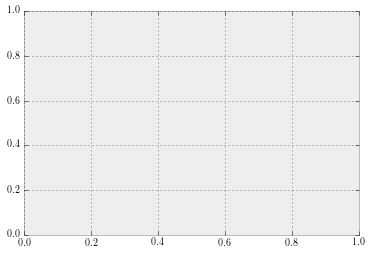

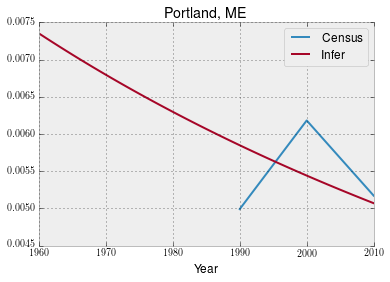

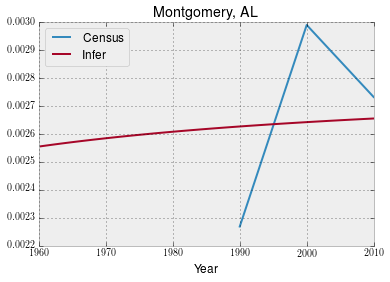

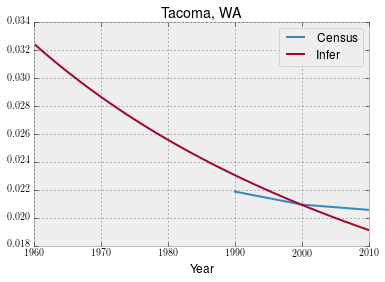

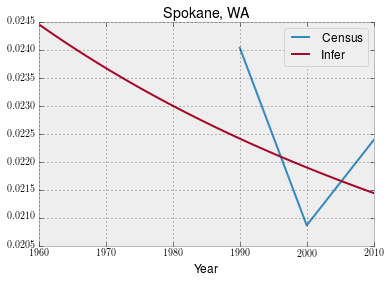

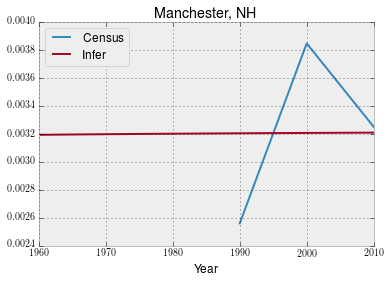

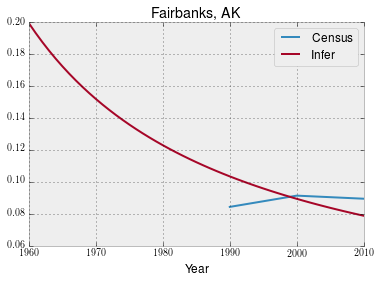

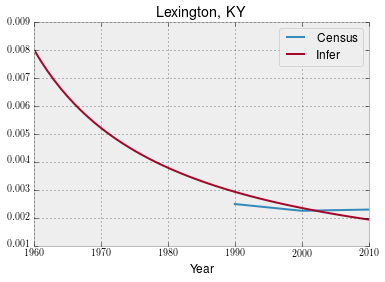

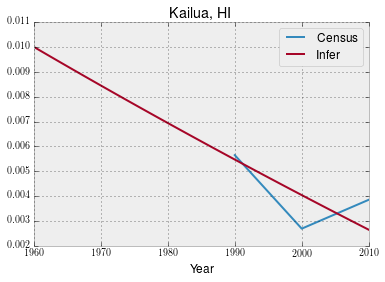

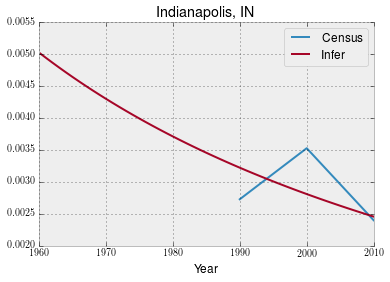

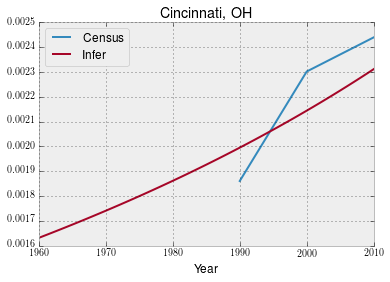

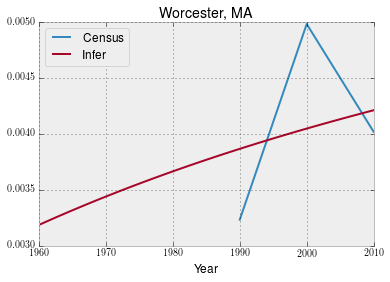

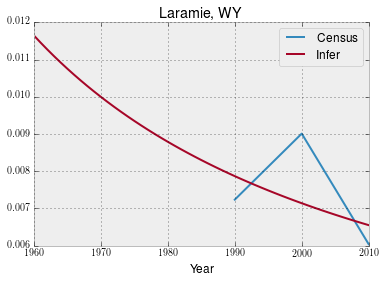

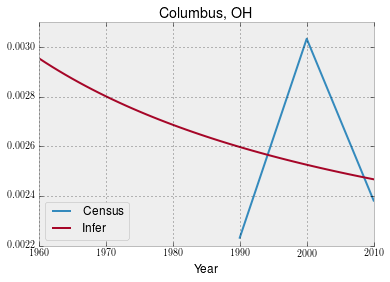

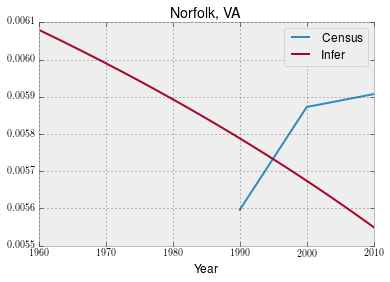

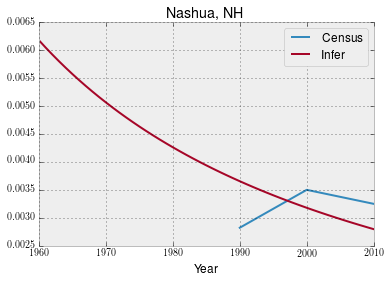

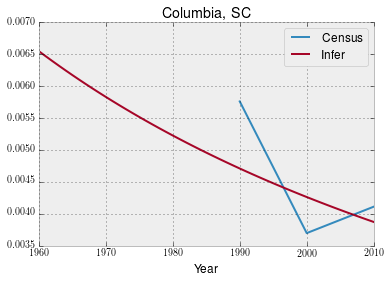

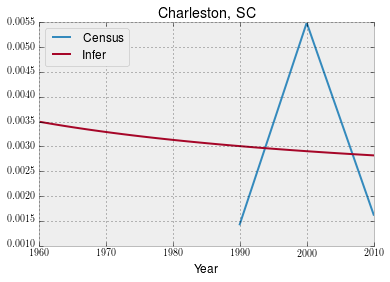

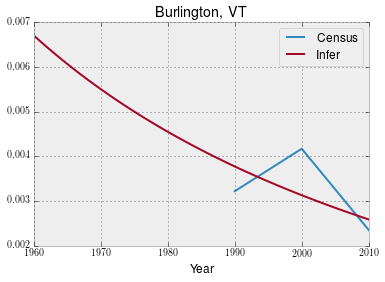

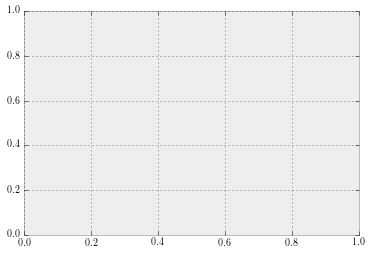

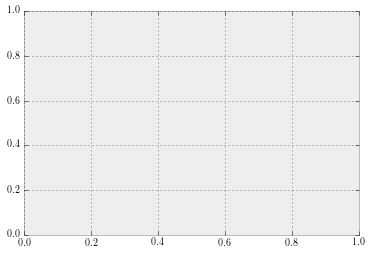

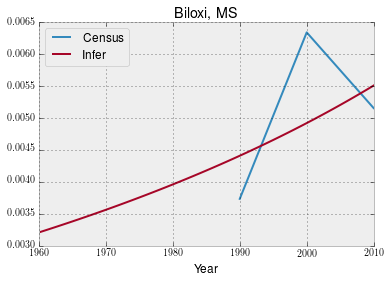

In [73]:
for city, state in delinqs.loc[:, ['City', 'State']].values:
    if True in [char.isupper() for char in city][1:]:
        upperchar = [l for l in city[1:] if l.isupper() == True][0]
        creplace = '_' + upperchar
        new_city = creplace.join(city.split(upperchar))
        plot_city(new_city, state, 'Native')
    else:
        plot_city(city, state, 'Native')

No Asian data for New_Orleans, LA
No Asian data for Salt_Lake_City, UT
No Asian data for Pine_Bluff, AR
No Asian data for Great_Falls, MT


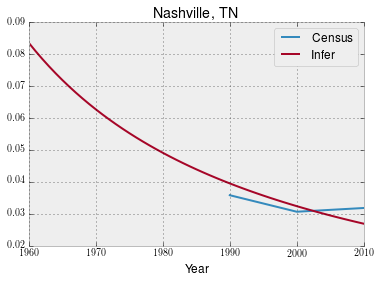

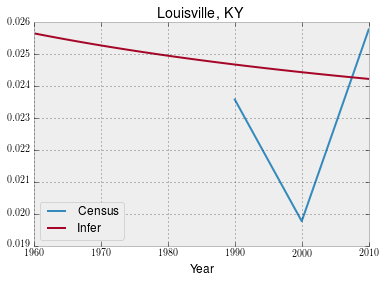

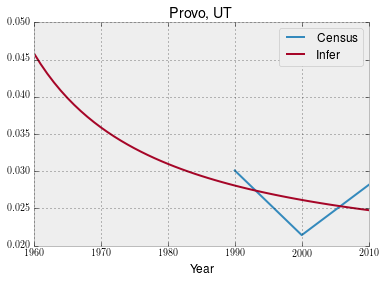

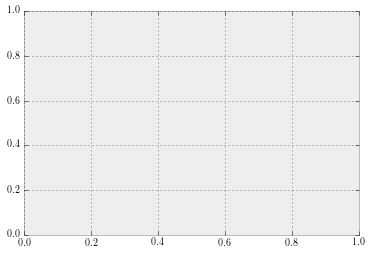

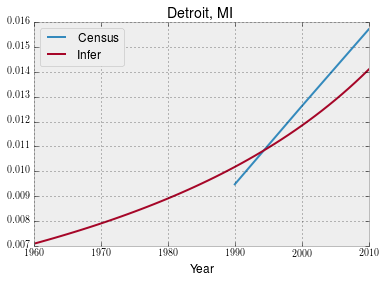

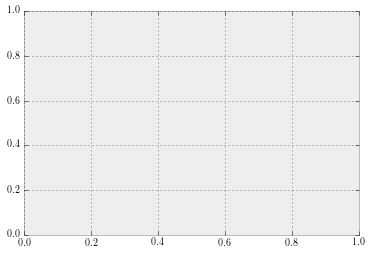

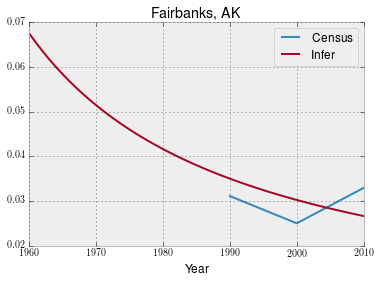

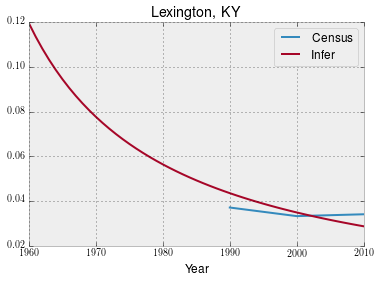

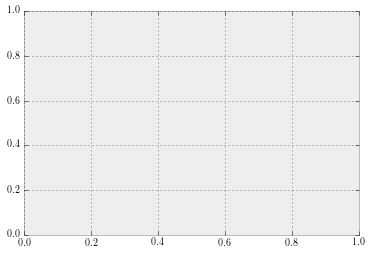

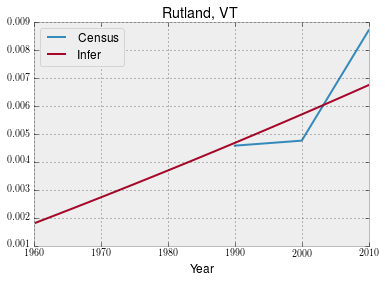

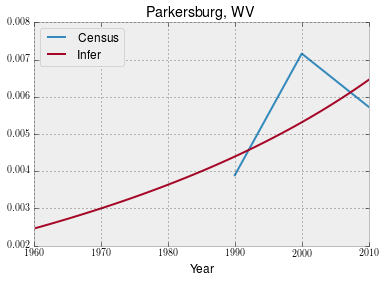

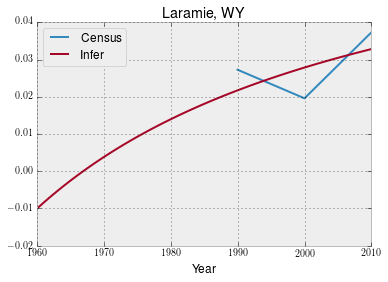

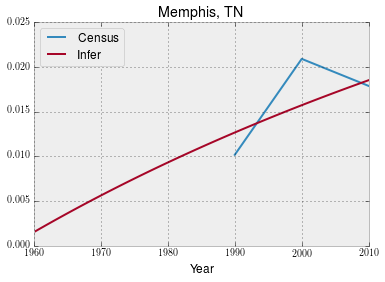

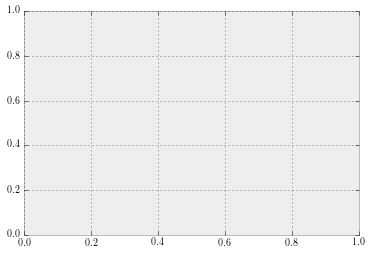

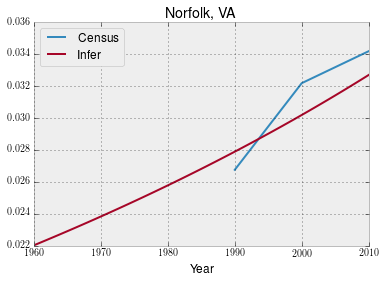

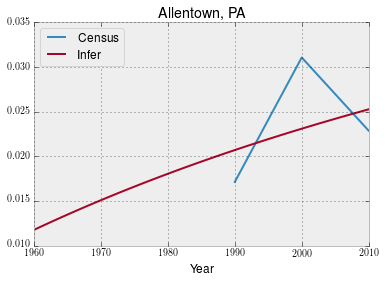

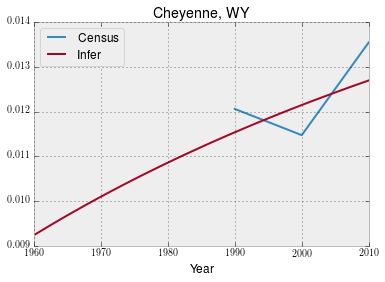

In [81]:
for city, state in df[(df.RacePop == 'AsianPop') & (df.Form == 1) & (df.RSquared < 0)].loc[:, ['City', 'State']].values:
    new_city = city
    if True in [char.isupper() for char in city][1:]:
        upperchars = [l for l in city[1:] if l.isupper() == True]
        for upperchar in upperchars:
            creplace = '_' + upperchar
            new_city = creplace.join(new_city.split(upperchar))        
    plot_city(new_city, state, 'Asian')

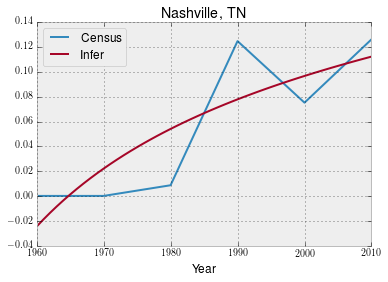

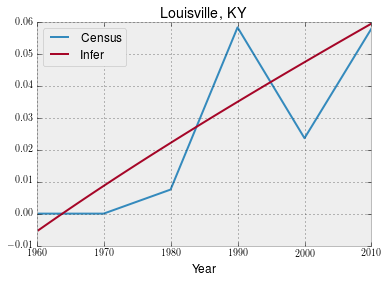

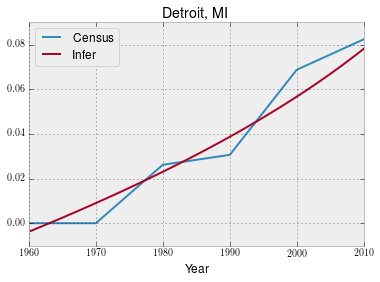

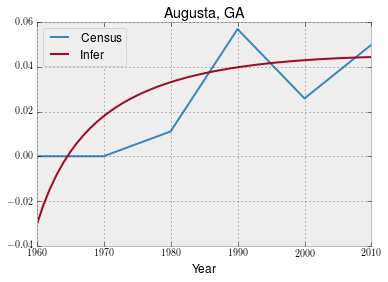

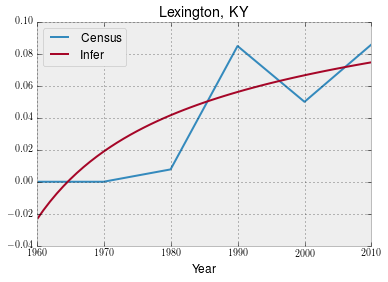

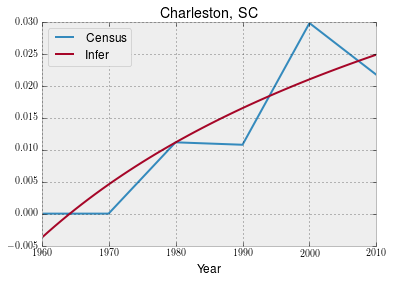

In [95]:
for city, state in df[(df.RacePop == 'HispanicPop') & (df.Form == 4) & (df.RSquared < 0)].loc[:, ['City', 'State']].values:
    new_city = city
    if True in [char.isupper() for char in city][1:]:
        upperchars = [l for l in city[1:] if l.isupper() == True]
        for upperchar in upperchars:
            creplace = '_' + upperchar
            new_city = creplace.join(new_city.split(upperchar))        
    plot_city(new_city, state, 'Hispanic')

No White data for Fort_Wayne, IN
No White data for Salt_Lake_City, UT


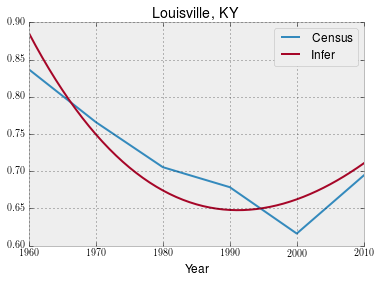

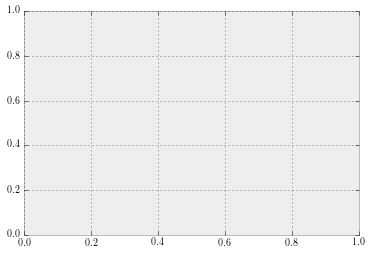

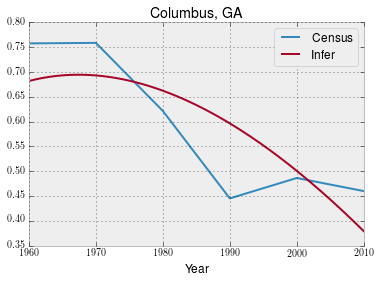

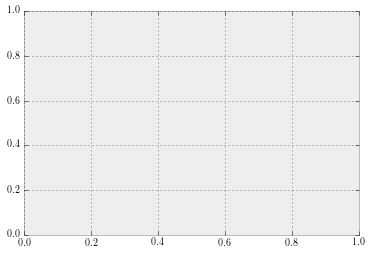

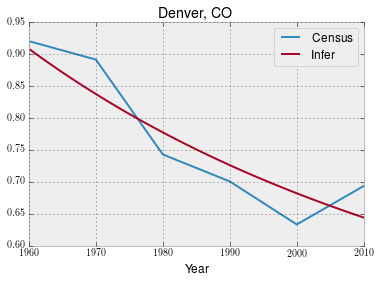

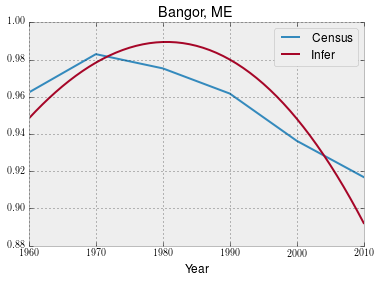

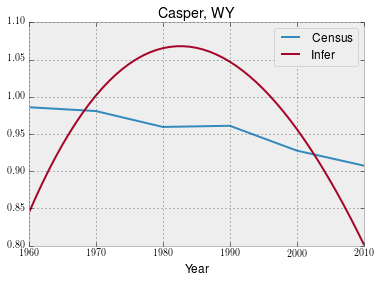

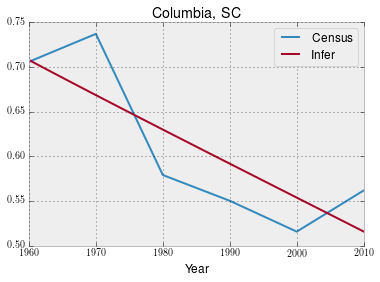

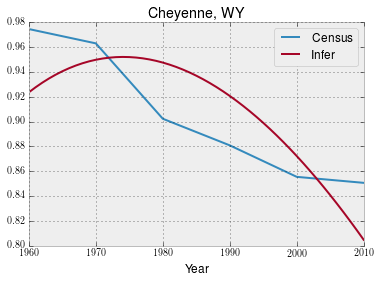

In [96]:
for city, state in df[(df.RacePop == 'WhitePop') & (df.Form == 4) & (df.RSquared < 0)].loc[:, ['City', 'State']].values:
    new_city = city
    if True in [char.isupper() for char in city][1:]:
        upperchars = [l for l in city[1:] if l.isupper() == True]
        for upperchar in upperchars:
            creplace = '_' + upperchar
            new_city = creplace.join(new_city.split(upperchar))        
    plot_city(new_city, state, 'White')

No Black data for Rapid_City, SD


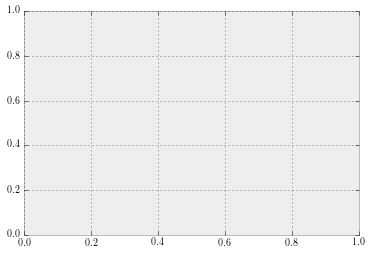

In [97]:
for city, state in df[(df.RacePop == 'BlackPop') & (df.Form == 4) & (df.RSquared < 0)].loc[:, ['City', 'State']].values:
    new_city = city
    if True in [char.isupper() for char in city][1:]:
        upperchars = [l for l in city[1:] if l.isupper() == True]
        for upperchar in upperchars:
            creplace = '_' + upperchar
            new_city = creplace.join(new_city.split(upperchar))        
    plot_city(new_city, state, 'Black')

In [134]:
df[(df.City == 'Casper') & (df.State == 'WY') & (df.RacePop == 'WhitePop')]

,City,State,RacePop,Form,RSquared
1856,Casper,WY,WhitePop,1,0.084414
1857,Casper,WY,WhitePop,2,0.319556
1858,Casper,WY,WhitePop,3,0.317074
1859,Casper,WY,WhitePop,4,0.314560


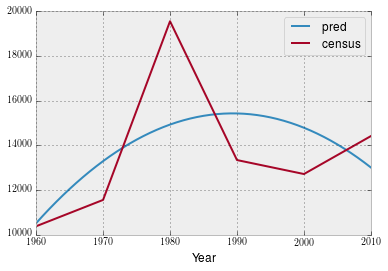

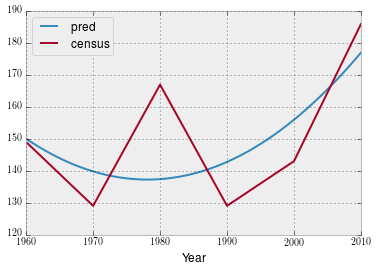

In [137]:
reload(dfunc)
pdf = dfunc.infer_single_census('../../Data/census/WY_Casper.csv', form = '%s ~ Year + np.power(Year, 2)')
for race in ['WhitePop', 'BlackPop']:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    pdf.plot(x='Year', y=race, ax=ax, label='pred')
    censusdf[(censusdf.State == 'WY') & (censusdf.City == 'Casper')].plot(x='Year', y=race, ax=ax, label='census')

In [128]:
#pdf is _y, census is _x
merged = pd.merge(censusdf, pdf, on=['City', 'State', 'Year'])
merged.loc[:, ['BlackPopFrac_x', 'BlackPopFrac_y', "Year"]]

,BlackPopFrac_x,BlackPopFrac_y,Year
0,0.014165,0.010965,1960
1,0.010954,0.010756,1970
2,0.008193,0.010569,1980
3,0.009295,0.010401,1990
4,0.010436,0.010249,2000
5,0.011713,0.010112,2010


# Current inference routine

In [28]:
reload(dfunc)
mdf = dfunc.produce_merged_dataframe(census_inference=True)

In [32]:
mdf.head()

,Year,State,City,TotalPop,WhitePop,WhitePopFrac,WhitePopYoY,WhitePopSlope,BlackPop,BlackPopFrac,...,TotalPopSlope,Region,Murder,Robbery,Assault,Burglary,MurderRate,RobberyRate,AssaultRate,BurglaryRate
0,1960,AK,Anchorage,19651.857143,6998.998904,0.356149,NaN,-0.002375,799.849004,0.040701,...,1612.565714,Non-contiguous,5,49,108,505,2.544289,24.934030,54.956638,256.973169
1,1961,AK,Anchorage,21264.422857,9989.002728,0.469752,0.011360,-0.002375,1007.399440,0.047375,...,1612.565714,Non-contiguous,5,42,82,323,2.351345,19.751300,38.562062,151.896904
2,1962,AK,Anchorage,22876.988571,12900.427426,0.563904,0.009415,-0.002375,1210.536491,0.052915,...,1612.565714,Non-contiguous,0,0,0,0,0.000000,0.000000,0.000000,0.000000
3,1963,AK,Anchorage,24489.554286,15733.018662,0.642438,0.007853,-0.002375,1409.245688,0.057545,...,1612.565714,Non-contiguous,6,70,92,464,2.450024,28.583615,37.567037,189.468536
4,1964,AK,Anchorage,26102.120000,18486.521833,0.708238,0.006580,-0.002375,1603.512547,0.061432,...,1612.565714,Non-contiguous,17,40,90,515,6.512881,15.324426,34.479958,197.301982


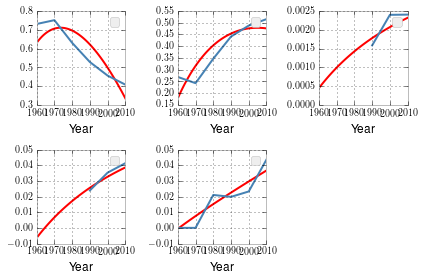

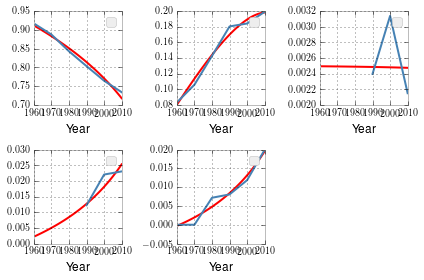

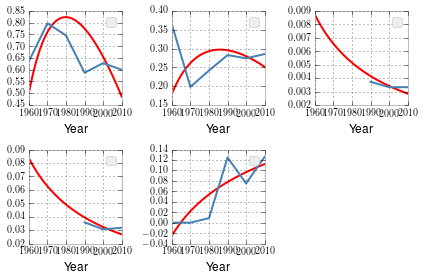

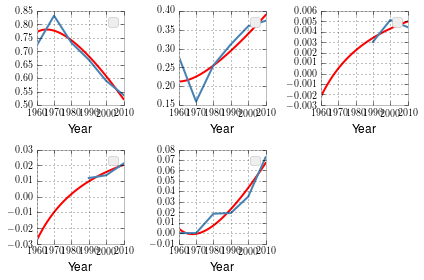

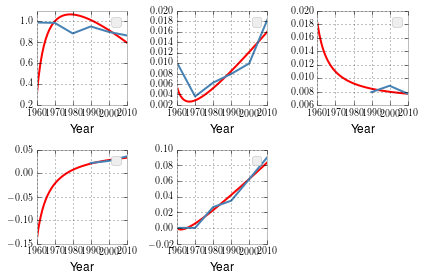

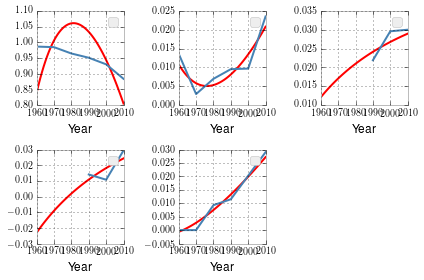

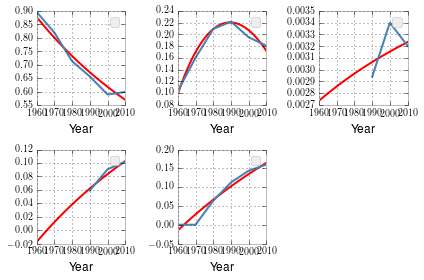

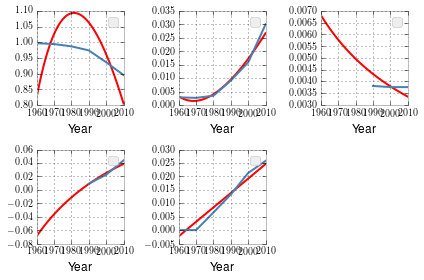

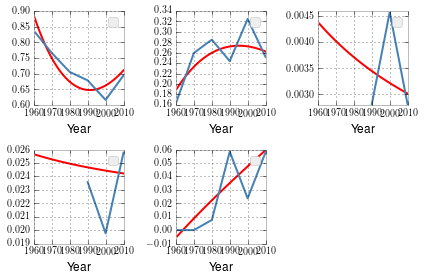

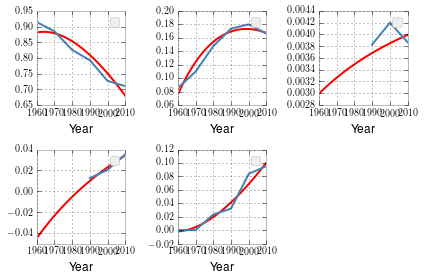

In [31]:
#Now lets plot the 
for city, state in cities[:10]:
    fig = plt.figure()
    for i, race in enumerate(['WhitePop', 'BlackPop', 'NativePop', 'AsianPop', 'HispanicPop']):
        ax = fig.add_subplot(2, 3, i+1, axisbg='white')
        #Inferred is red
        ax = mdf[(mdf.City == city) & (mdf.State == state)].plot(x='Year', y=race+'Frac', ax = ax, color='red')
        #Census fraction is blue
        ax = censusdf[(censusdf.City == city) & (censusdf.State == state)].plot(x='Year', y=race+'Frac', ax = ax, color='steelblue')
        ax.legend('')
    plt.tight_layout()

# Restricting to cities larger than 50k population across all decades

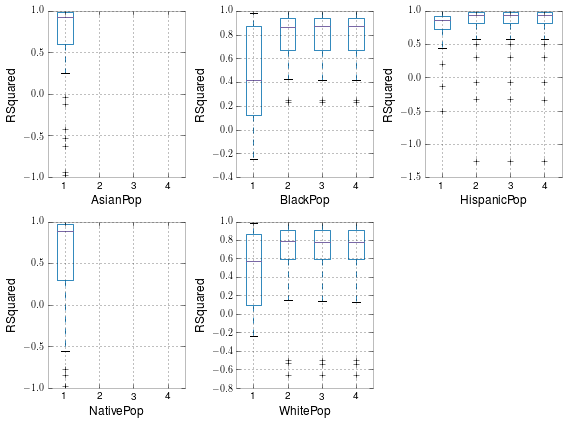

In [186]:
fig = plt.figure(figsize = (8, 6))

for i, race in enumerate(df.RacePop.unique()):
    ax = fig.add_subplot(2, 3, i+1)
    ax = merge_adjdf[merge_adjdf.RacePop == race].boxplot(ax = ax, column = 'RSquared', by='Form')
    ax.set_title('')
    ax.set_ylabel('RSquared')
    ax.set_xlabel(race)
    ax.set_axis_bgcolor('white')

fig.suptitle('')
plt.tight_layout()

Denver CO
Louisville KY
SaltLakeCity UT
No White data for Salt_Lake_City, UT
Detroit MI
Louisville KY
Nashville TN


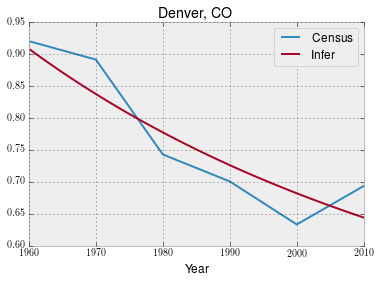

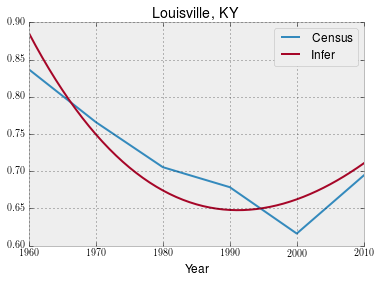

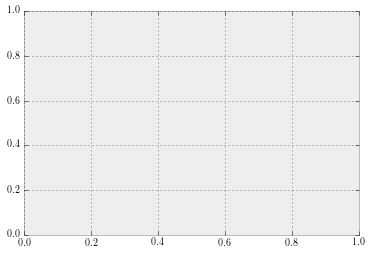

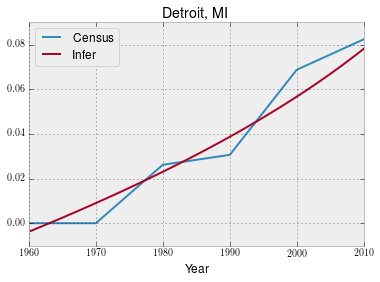

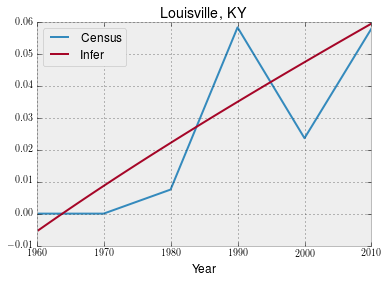

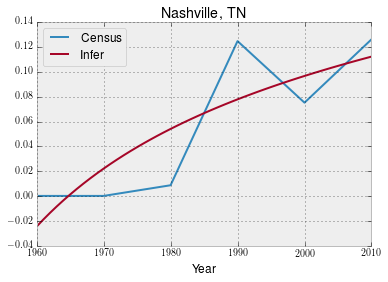

In [200]:
for race in ['Black', 'White', 'Hispanic']:
    for city, state in merge_adjdf[(merge_adjdf.RacePop == race + 'Pop') & (merge_adjdf.Form == 2) & \
                          (merge_adjdf.RSquared < 0)].loc[:, ['City', 'State']].values:
        print(city, state)
        new_city = city
        if True in [char.isupper() for char in city][1:]:
            upperchars = [l for l in city[1:] if l.isupper() == True]
            for upperchar in upperchars:
                creplace = '_' + upperchar
                new_city = creplace.join(new_city.split(upperchar))        
        plot_city(new_city, state, race)

# Veterans funnes.

In [15]:
reload(dfunc)

cvetpop = dfunc.load_veteran_population_by_conflict()

In [16]:
cvetpop['Total']

,Conflict,Estimate,Error,Year
0,Total,23427584,66828,2005
0,Total,23425051,61909,2006
0,Total,22892086,54670,2007
0,Total,22424712,67194,2008
0,Total,21854374,65089,2009
0,Total,21798077,63662,2010
0,Total,21458427,67640,2011
0,Total,21230865,57501,2012
0,Total,19588586,58435,2013
0,Total,19259717,63735,2014
